<span style="font-size: 30px;">Taller Machine learning I</span>

<span style="font-size: 20px;">Integrantes</span>

# Librerias

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.style.use('ggplot')

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Funciones utils

## Gráficas

In [3]:
def box_plot(df: pd.DataFrame, showfliers: bool = True):
    """Genera un diagrama de cajas utilizando el mapa de colores RdYlGn.

    Args:
        df (pd.DataFrame): El DataFrame que se utilizará para generar 
         el diagrama de cajas.
        showfliers (bool): Indica si se muestran o no los valores 
         atípicos en el diagrama de cajas. Valor predeterminado es True.

    Returns:
        None: Muestra el gráfico de barras.
        
    """
    # Generar el diagrama de cajas utilizando df.plot(kind='box')
    ax = df.plot(kind='box', patch_artist=True, figsize=(8, 5), showfliers=showfliers, vert=False)
    
    # Configurar el mapa de colores
    cmap = plt.cm.RdYlGn
    
    # Personalizar el color de las cajas utilizando el mapa de colores
    for patch, color in zip(ax.artists, cmap(np.linspace(0.1, 0.9, len(ax.artists)))):
        patch.set_facecolor(color)

    plt.show()

In [4]:
def plot_correlation(df: pd.DataFrame) -> None:
    """Grafica una matriz de correlación para un DataFrame dado.

    Args:
        df (pandas.DataFrame): DataFrame que contiene los datos.

    Returns:
        None: Muestra el gráfica de correlación.

    """
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Matriz de correlación")
    plt.show()

In [37]:
def plot_learning_curve(model, X, y, train_sizes, cv):
    """ Grafica las curvas de aprendizaje para un modelo de regresión lineal.

    Args:
        model: Modelo de regresión lineal ya ajustado.
        X (array-like): Datos de entrada.
        y (array-like): Valores objetivo.
        train_sizes (array-like): Tamaños del conjunto de entrenamiento a evaluar.
        cv (int): Número de divisiones para la validación cruzada.

    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Puntuación de entrenamiento')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Puntuación de validación')

    plt.fill_between(
        train_sizes, 
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, 
        alpha=0.1, 
        color='blue')
    plt.fill_between(
        train_sizes, 
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, 
        alpha=0.1, 
        color='red')

    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Puntuación')
    plt.title('Curvas de Aprendizaje')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

## Análisis

In [5]:
def corr_features(correlation_matrix: pd.DataFrame, 
                  threshold: float) -> None:
    """Encuentra las características altamente relacionadas 
     basadas en una matriz de correlación y un umbral dado.

    Args:
        correlation_matrix: Matriz de correlación.
        threshold: Umbral para considerar una alta correlación.

    Returns:
        list: Lista de pares de características altamente relacionadas.

    """
    correlated_features = []
    n_features = len(correlation_matrix.columns)

    for i in range(n_features):
        for j in range(i + 1, n_features):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                feature_i = correlation_matrix.columns[i]
                feature_j = correlation_matrix.columns[j]
                correlated_features.append((feature_i, feature_j))

    return correlated_features

# Carga de datos

In [6]:
path = os.path.join('..', 'data', 'youtube_model.parquet')
youtube_model = pd.read_parquet(path)

In [7]:
youtube_model.head(2)

,views,likes,dislikes,comment_count,days,title_length,tag_count,category
0,2418783,97185,6146,12703,0,62,4,Entertainment
1,343168,10172,666,2146,0,32,27,Entertainment


# Exploración

* Inicialmente no tendremos en cuenta la variable objetivo

In [8]:
youtube_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34669 entries, 0 to 34668
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   views          34669 non-null  int64 
 1   likes          34669 non-null  int64 
 2   dislikes       34669 non-null  int64 
 3   comment_count  34669 non-null  int64 
 4   days           34669 non-null  int64 
 5   title_length   34669 non-null  int64 
 6   tag_count      34669 non-null  int64 
 7   category       34669 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.1+ MB


In [9]:
cols = ['views', 'dislikes', 'comment_count', 'days', 'title_length', 'tag_count']

In [10]:
youtube = youtube_model[cols]

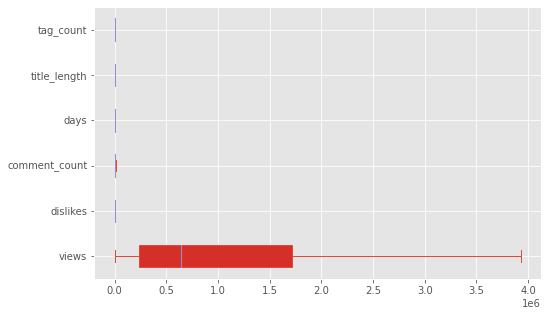

In [11]:
box_plot(youtube, showfliers=False)

* Escalamos los datos para tener una visión clara

In [12]:
min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(youtube)
numeric_scale = pd.DataFrame(numeric_scale, columns=youtube.columns)

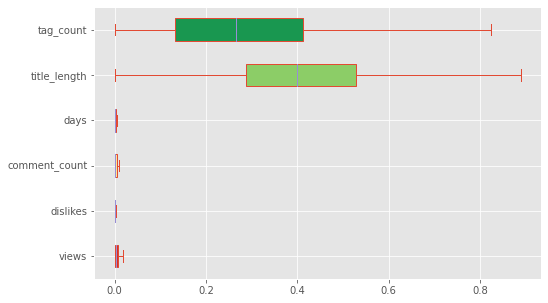

In [13]:
box_plot(numeric_scale, showfliers=False)

In [14]:
youtube.describe()

,views,dislikes,comment_count,days,title_length,tag_count
count,3.466900e+04,3.466900e+04,3.466900e+04,34669.000000,34669.000000,34669.000000
mean,2.288998e+06,3.501578e+03,7.609041e+03,16.885604,47.919640,19.704895
std,7.396248e+06,2.999773e+04,3.070281e+04,150.651921,19.478644,11.974529
min,5.490000e+02,0.000000e+00,0.000000e+00,-1.000000,3.000000,1.000000
25%,2.345420e+05,1.960000e+02,6.130000e+02,2.000000,34.000000,10.000000
50%,6.454490e+05,5.970000e+02,1.807000e+03,5.000000,46.000000,19.000000
75%,1.711967e+06,1.799000e+03,5.513000e+03,8.000000,60.000000,29.000000
max,2.252119e+08,1.674420e+06,1.361580e+06,4214.000000,111.000000,69.000000


* Correlación lineal

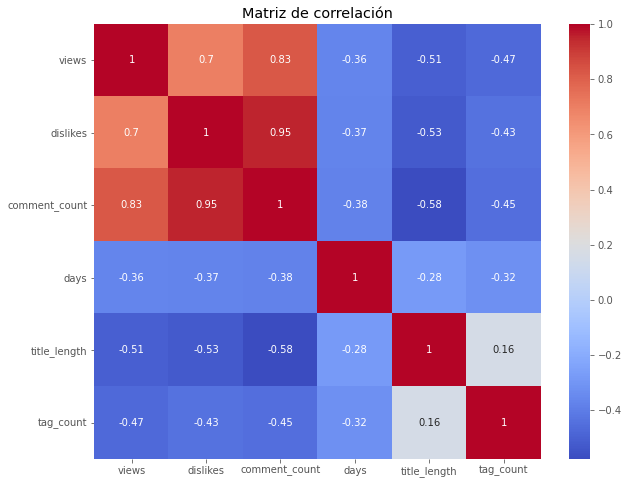

In [15]:
plot_correlation(youtube.corr())

In [16]:
corr_features(youtube.corr(), 0.07)

[('views', 'dislikes'),
 ('views', 'comment_count'),
 ('dislikes', 'comment_count'),
 ('comment_count', 'title_length'),
 ('title_length', 'tag_count')]

In [17]:
drop_cols = ['title_length']

In [18]:
youtube_model.drop(drop_cols, axis=1, inplace=True)

In [19]:
youtube_model.head()

,views,likes,dislikes,comment_count,days,tag_count,category
0,2418783,97185,6146,12703,0,4,Entertainment
1,343168,10172,666,2146,0,27,Entertainment
2,2095731,132235,1989,17518,1,14,Entertainment
3,817732,23663,778,3432,1,13,Science & Technology
4,826059,3543,119,340,0,28,Film & Animation


# Trasformaciones

In [20]:
youtube_regresion = pd.get_dummies(youtube_model, columns=['category'], dtype=int)

In [21]:
youtube_regresion.head()

,views,likes,dislikes,comment_count,days,tag_count,category_Comedy,category_Entertainment,category_Film & Animation,category_Howto & Style,category_Music,category_News & Politics,category_Other,category_People & Blogs,category_Science & Technology,category_Sports
0,2418783,97185,6146,12703,0,4,0,1,0,0,0,0,0,0,0,0
1,343168,10172,666,2146,0,27,0,1,0,0,0,0,0,0,0,0
2,2095731,132235,1989,17518,1,14,0,1,0,0,0,0,0,0,0,0
3,817732,23663,778,3432,1,13,0,0,0,0,0,0,0,0,1,0
4,826059,3543,119,340,0,28,0,0,1,0,0,0,0,0,0,0


In [22]:
x = youtube_regresion.drop('likes', axis=1)
y = youtube_regresion['likes']

## Escalamiento de datos

In [23]:
min_max = MinMaxScaler()

numeric_scale = min_max.fit_transform(x)

numeric_scale = pd.DataFrame(numeric_scale, columns=x.columns)

# Modelos

## Regresión lineal

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    numeric_scale, y, train_size=0.8, random_state=1234, shuffle=True
)

In [25]:
lr = LinearRegression()

In [26]:
lr.fit(x_train, y_train)

LinearRegression()

In [27]:
y_predict = lr.predict(x_test)

In [28]:
r2_score(y_test, y_predict)

0.916148644668527

### Curvas de aprendizaje

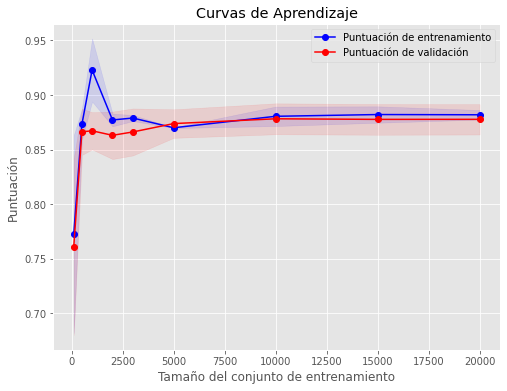

In [36]:
train_sizes = [100, 500, 1000, 2000, 3000, 5000, 10000, 15000, 20000]

plot_learning_curve(lr, x_train, y_train, train_sizes=train_sizes, cv=5)

In [33]:
x_train.shape

(27735, 15)

## Random Forest Regressor

* Usamos GridSearchCV para buscar el mejor modelo

In [43]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]}

In [44]:
rf = RandomForestRegressor(random_state=1234)

In [45]:
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5, 
    scoring='r2')

In [46]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [47]:
r_params = grid_search.best_params_
r_model = grid_search.best_estimator_

In [48]:
y_pred = r_model.predict(x_test)

In [49]:
accuracy = r2_score(y_test, y_pred)
print("Exactitud del modelo: {:.2f}%".format(accuracy * 100))

Exactitud del modelo: 98.06%
